## Import Libraries

In [76]:
import numpy as np
import pandas as pd
from IPython.display import display
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Importacion del dataset de PRoperaty pre-Procesado anteriormente

In [77]:
dfprop=pd.read_csv(filepath_or_buffer='properati_buffered.csv',delimiter=',',index_col = 0 )

Se elimina las columnas 'cota_inf' y 'cota_sup'.
Adicionalmente se genera una columna unificando la ubicacion

In [78]:

dfprop.drop(['cota_inf','cota_sup'],axis=1,inplace=True)

In [79]:
# Generamos una key de zona
dfprop['district_name_key']=dfprop['country_name']+"-"+\
                            dfprop['state_name']+"-"+\
                            dfprop['district_name']


## Construccion de Dummies
-  Efectuar una inspeccion de los campos title y description para indicar la existencia de palabras claves 

In [80]:
def new_dummy_from_included_in_column(dfprop_aux,column,word):
    #dfprop_aux=dfprop
    #word='POZO'
    
    #Creamos la expresion regular ..."que el texto empiece con"... word 
    re_word="("+word+")"
    
    #Creamos la expresion regular
    re_search=dfprop[column].str.extract(re_word,expand=False)
    
    #re_search[((re_search!=-1)&(~(pd.isna(re_search))))].index
    #Creamos la columna dummy y seteamos todos los rows en 0
    dfprop_aux.loc[:,"dm_"+word]=0
    
    #Extraemos la lista de de indices donde la expresion se cumple
    prop_re_list =np.array(re_search[((re_search!=-1)&(~(pd.isna(re_search))))].index)
    
    #Actualizamos el valor de la columna Dummy a 1 en los casos dentro del indice enviado
    dfprop_aux.loc[dfprop_aux.index.isin(prop_re_list),"dm_"+word]=1
    
    print_dummy_count_rows(dfprop_aux,"dm_"+word)
    
    return dfprop_aux


def print_dummy_count_rows(dfprop_aux_p,word_p):
    print('Cantidad de rows con '+word_p+": ",dfprop_aux_p.loc[dfprop_aux_p[word_p]==1,'operation'].count())
    

In [81]:
def generate_dummies_per_location(dfprop_aux):
    total_district_name_key=len(dfprop_aux['district_name_key'].unique())
    i=1
    for district_name_key in dfprop_aux['district_name_key'].unique():
        #print(str(i)+" de "+str(total_district_name_key)+" - Generando Dummy para localidad: "+district_name_key)
        dfprop_aux=new_dummy_from_included_in_column(dfprop_aux,'district_name_key',district_name_key)
        i+=1
    return dfprop_aux

In [82]:
def plot_price_dispersion(dfprop_plot):
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.catplot(y="district_name_key", x="price_usd_per_m2", data=dfprop_plot,ax=ax);

In [83]:
def clean_outliers(dfprop_outlier):
    # Agrupamos por key y sacamos precio promedio
    dfprop_quartile=dfprop_outlier.groupby(by = ['district_name_key'])["price_usd_per_m2"].describe()
    dfprop_quartile['district_name_key']=dfprop_quartile.index
    dfprop_group_quartiles=dfprop_quartile[['25%','75%','district_name_key']]
    dfprop_group_quartiles['cota_inf']=dfprop_group_quartiles['25%']-((dfprop_group_quartiles['75%']-dfprop_group_quartiles['25%'])*1.5)
    dfprop_group_quartiles['cota_sup']=dfprop_group_quartiles['75%']+((dfprop_group_quartiles['75%']-dfprop_group_quartiles['25%'])*1.5)
    dfprop_group_quartiles=dfprop_group_quartiles[['cota_inf','cota_sup']]
    dfprop_group_quartiles
    dfprop_outlier=pd.merge(dfprop_outlier,dfprop_group_quartiles,how='left',on='district_name_key')
    dfprop_outlier=dfprop_outlier.loc[(dfprop_outlier['price_usd_per_m2']>dfprop_outlier['cota_inf'])&(dfprop_outlier['price_usd_per_m2']<dfprop_outlier['cota_sup'])]
    
    #Eliminamos las cotas
    dfprop_outlier.drop(['cota_inf','cota_sup'],axis=1,inplace=True)
    
    return dfprop_outlier

In [84]:
a=dfprop.columns
for i in a:
    print("'"+i+"',")

'operation',
'property_type',
'place_name',
'place_with_parent_names',
'country_name',
'state_name',
'geonames_id',
'lat-lon',
'lat',
'lon',
'price',
'currency',
'price_aprox_local_currency',
'price_aprox_usd',
'surface_total_in_m2',
'surface_covered_in_m2',
'price_usd_per_m2',
'price_per_m2',
'floor',
'rooms',
'expenses',
'properati_url',
'description',
'title',
'image_thumbnail',
'district_name',
'city_name',
'district_name_key',


In [85]:
def getFeaturers(dfprop_in):
    column_features=[
        #'surface_total_in_m2',
    'dm_house',
    'dm_apartment',   
    'dm_PH',
    'rooms',
    'baños_desc',
    'floor',
    'dm_planta alta',
    'dm_cochera',
    'dm_cocheras',
    'dm_vestidor',
    'dm_baulera',
    'dm_suite',
    'dm_pisos',
    'dm_azotea',
    'dm_terraza',
    'dm_caldera',
    'dm_balcon',
    'dm_palier',
    'dm_pileta',
    'dm_hall',
    'dm_seguridad',
    'dm_estrenar',
    'dm_condominio',
    'dm_construccion',
    'dm_quincho',
    'dm_vigilancia',
    'dm_obra',
    'dm_parrilla',
    'dm_barrio cerrado',
    'dm_monoambiente',
    'dm_escuela',
    'dm_expensa','dm_pileta'
    ]

    #District_key
    for loc in dfprop['district_name_key'].unique():
        column_features.append('dm_'+loc) 

    return column_features

Se generan 3 Dummies para separar los tipos de propiedad 

In [86]:
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','PH')
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','apartment')
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','house')

Cantidad de rows con dm_PH:  5099
Cantidad de rows con dm_apartment:  62525
Cantidad de rows con dm_house:  31956


In [87]:
print_dummy_count_rows(dfprop,'dm_PH')
print_dummy_count_rows(dfprop,'dm_apartment')
print_dummy_count_rows(dfprop,'dm_house')

Cantidad de rows con dm_PH:  5099
Cantidad de rows con dm_apartment:  62525
Cantidad de rows con dm_house:  31956


In [88]:
dfprop['state_name'].unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Norte',
       'Santa Fe', 'Córdoba', 'Bs.As. G.B.A. Zona Oeste', 'Misiones',
       'Entre Ríos', 'Buenos Aires Interior', 'Neuquén', 'San Luis',
       'Río Negro', 'Salta', 'Mendoza', 'Tucumán', 'Corrientes', 'Chubut'],
      dtype=object)

In [89]:
#dfprop = dfprop.loc[dfprop['state_name']=='Capital Federal',:]

In [90]:
dfprop=generate_dummies_per_location(dfprop)

Cantidad de rows con dm_Argentina-Capital Federal-Mataderos:  378
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Sur-La Plata:  2691
Cantidad de rows con dm_Argentina-Capital Federal-Liniers:  385
Cantidad de rows con dm_Argentina-Buenos Aires Costa Atlántica-Mar del Plata:  7216
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-Vicente López:  3456
Cantidad de rows con dm_Argentina-Capital Federal-Belgrano:  2753
Cantidad de rows con dm_Argentina-Santa Fe-Rosario:  7181
Cantidad de rows con dm_Argentina-Córdoba-Córdoba:  5652
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-San Miguel:  1168
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-San Isidro:  2827
Cantidad de rows con dm_Argentina-Capital Federal-Palermo:  3698
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-Tigre:  8403
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Oeste-General Rodríguez:  134
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Norte-Pilar:  2965
Cantid

Cantidad de rows con dm_Argentina-Buenos Aires Interior-Tandil:  70
Cantidad de rows con dm_Argentina-Mendoza-San Rafael:  77
Cantidad de rows con dm_Argentina-Buenos Aires Interior-San Pedro:  6
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Sur-Presidente Perón:  114
Cantidad de rows con dm_Argentina-Buenos Aires Costa Atlántica-Mar Azul:  29
Cantidad de rows con dm_Argentina-San Luis-San Luis:  53
Cantidad de rows con dm_Argentina-Buenos Aires Costa Atlántica-Valeria del Mar:  53
Cantidad de rows con dm_Argentina-Capital Federal-Pompeya:  45
Cantidad de rows con dm_Argentina-Capital Federal-Villa General Mitre:  45
Cantidad de rows con dm_Argentina-Córdoba-Río Cuarto:  51
Cantidad de rows con dm_Argentina-Bs.As. G.B.A. Zona Sur-San Vicente:  122
Cantidad de rows con dm_Argentina-Buenos Aires Interior-Coronel Suárez:  21
Cantidad de rows con dm_Argentina-Buenos Aires Interior-San Miguel del Monte:  14
Cantidad de rows con dm_Argentina-Neuquén-Lácar:  11
Cantidad de rows con dm_

In [91]:
#Buscamos la descripción para extraer información sobre la cantidad de baños:
baños_desc = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'baño', str(dfprop['description'].iloc[i]), flags = re.IGNORECASE):
        baños_desc.append(float(re.search(r"\d",re.search(r"\d\s"+'baño', dfprop['description'].iloc[i], flags = re.IGNORECASE).group()).group()))
    elif re.search(r"\d\s"+'bano', str(dfprop['description'].iloc[i]), flags = re.IGNORECASE):
        baños_desc.append(float(re.search(r"\d",re.search(r"\d\s"+'bano', dfprop['description'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        baños_desc.append(np.nan)
dfprop['baños_desc'] = baños_desc
dfprop.fillna({'baños_desc': 1}, inplace= True)

In [92]:
#Buscamos la descripción para extraer información sobre el piso:
piso_desc = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'piso', str(dfprop['description'].iloc[i]), flags = re.IGNORECASE):
        piso_desc.append(float(re.search(r"\d",re.search(r"\d\s"+'piso', dfprop['description'].iloc[i], flags = re.IGNORECASE).group()).group()))
    elif re.search('piso'+r"s\d\s", str(dfprop['description'].iloc[i]), flags = re.IGNORECASE):
        piso_desc.append(float(re.search(r"\d",re.search('piso'+r"s\d\s", dfprop['description'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        piso_desc.append(np.nan)
dfprop['piso_desc'] = piso_desc
piso_title = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'piso', str(dfprop['title'].iloc[i]), flags = re.IGNORECASE):
        piso_title.append(float(re.search(r"\d",re.search(r"\d\s"+'piso', dfprop['title'].iloc[i], flags = re.IGNORECASE).group()).group()))
    elif re.search('piso'+r"s\d\s", str(dfprop['title'].iloc[i]), flags = re.IGNORECASE):
        piso_title.append(float(re.search(r"\d",re.search('piso'+r"s\d\s", dfprop['title'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        piso_title.append(np.nan)
dfprop['piso_title'] = piso_title
dfprop.fillna({'piso_title' : dfprop['piso_desc']}, inplace= True)
dfprop.fillna({'floor' : dfprop['piso_title']}, inplace = True)
dfprop.fillna({'floor': 0}, inplace= True)

In [93]:
dfprop['floor'].describe()

count    99580.000000
mean         1.542167
std         32.240055
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2509.000000
Name: floor, dtype: float64

In [94]:
ambientes_desc = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'amb', str(dfprop['description'].iloc[i]), flags = re.IGNORECASE):
        ambientes_desc.append(float(re.search(r"\d",re.search(r"\d\s"+'amb', dfprop['description'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        ambientes_desc.append(np.nan)
dfprop['ambientes_desc'] = ambientes_desc


In [95]:
ambientes_title = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'amb', str(dfprop['title'].iloc[i]), flags = re.IGNORECASE):
        ambientes_title.append(float(re.search(r"\d",re.search(r"\d\s"+'amb', dfprop['title'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        ambientes_title.append(np.nan)
dfprop['ambientes_title'] = ambientes_title

In [96]:
dfprop.fillna({'ambientes_title' : dfprop['ambientes_desc']}, inplace = True)
dfprop.fillna({'rooms' : dfprop['ambientes_title']}, inplace = True)
dfprop.loc[dfprop['rooms'] != dfprop['ambientes_title'], 'rooms'] = dfprop.loc[dfprop['rooms'] != dfprop['ambientes_title'], 'ambientes_title']
#descartamos las columnas 'ambientes_title' y 'ambientes_desc' para evitar confusiones
dfprop = dfprop.drop(labels = ['ambientes_title', 'ambientes_desc'], axis = 1)

In [97]:
dfprop = dfprop[dfprop['rooms'].isna() == False]

## Analisis de Outliers

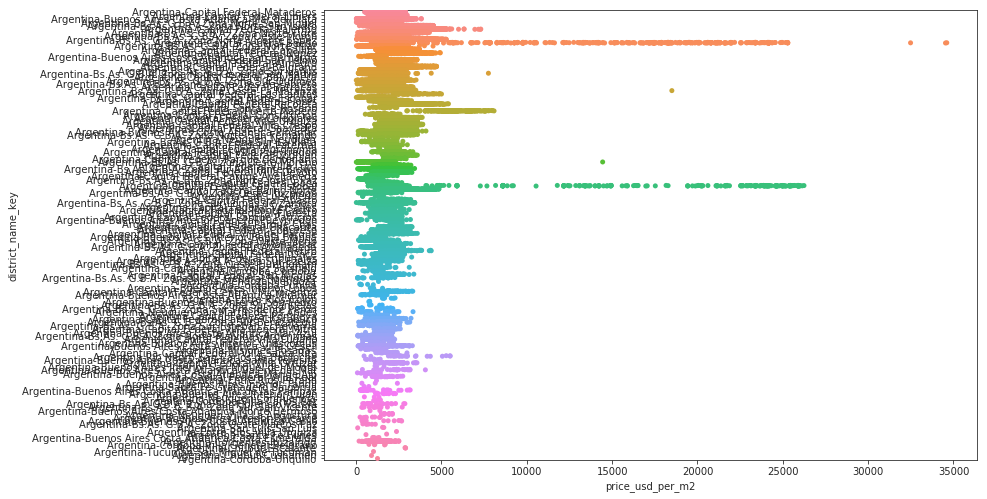

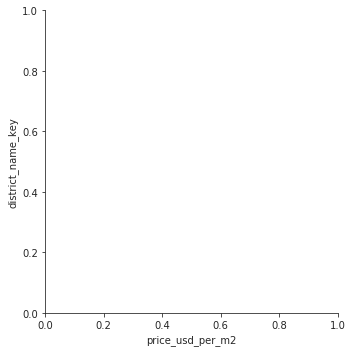

In [98]:
plot_price_dispersion(dfprop)

Consideramos un precio mayor a 8000 USD_per_m2 un valor incorrecto

In [99]:
#Capital Federal
dfprop=dfprop.loc[dfprop['price_usd_per_m2']<8000]


#dfprop=dfprop.loc[dfprop['price_usd_per_m2']>1000]

Limpiamos outliers

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


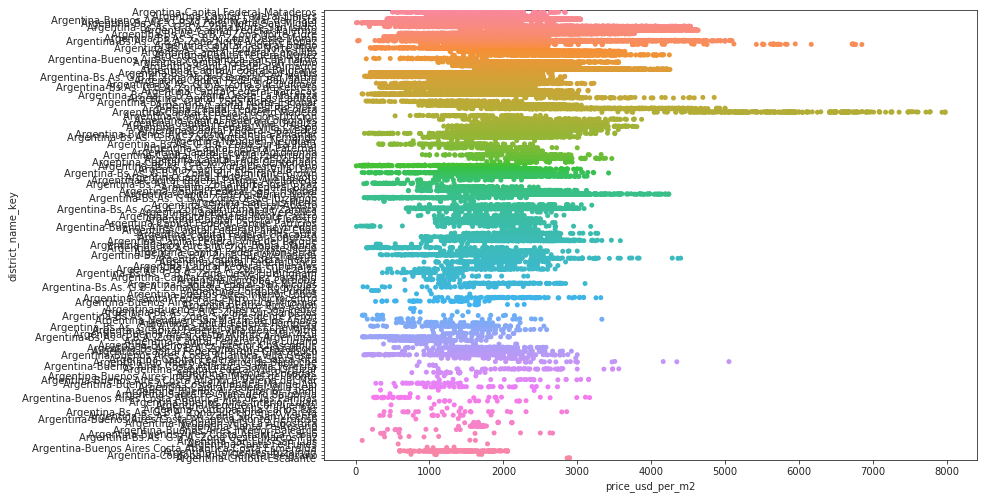

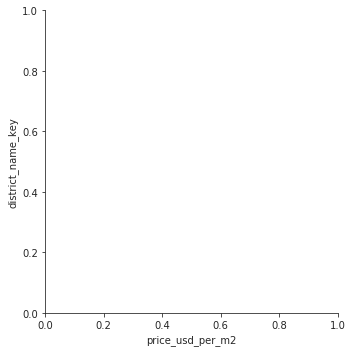

In [100]:
dfprop=clean_outliers(dfprop)
plot_price_dispersion(dfprop)

In [101]:
dfprop['description']=dfprop['description'].str.lower()
dfprop=new_dummy_from_included_in_column(dfprop,'description','planta alta')
dfprop=new_dummy_from_included_in_column(dfprop,'description','cochera')
dfprop=new_dummy_from_included_in_column(dfprop,'description','cocheras')
dfprop=new_dummy_from_included_in_column(dfprop,'description','vestidor')
dfprop=new_dummy_from_included_in_column(dfprop,'description','baulera')
dfprop=new_dummy_from_included_in_column(dfprop,'description','suite')
dfprop=new_dummy_from_included_in_column(dfprop,'description','pisos')
dfprop=new_dummy_from_included_in_column(dfprop,'description','azotea')
dfprop=new_dummy_from_included_in_column(dfprop,'description','terraza')
dfprop=new_dummy_from_included_in_column(dfprop,'description','caldera')
dfprop=new_dummy_from_included_in_column(dfprop,'description','balcon')
dfprop=new_dummy_from_included_in_column(dfprop,'description','palier')
dfprop=new_dummy_from_included_in_column(dfprop,'description','pileta')
dfprop=new_dummy_from_included_in_column(dfprop,'description','hall')
dfprop=new_dummy_from_included_in_column(dfprop,'description','seguridad')
dfprop=new_dummy_from_included_in_column(dfprop,'description','estrenar')
dfprop=new_dummy_from_included_in_column(dfprop,'description','condominio')
dfprop=new_dummy_from_included_in_column(dfprop,'description','construccion')
dfprop=new_dummy_from_included_in_column(dfprop,'description','quincho')
dfprop=new_dummy_from_included_in_column(dfprop,'description','vigilancia')
dfprop=new_dummy_from_included_in_column(dfprop,'description','obra')
dfprop=new_dummy_from_included_in_column(dfprop,'description','parrilla')
dfprop=new_dummy_from_included_in_column(dfprop,'description','barrio cerrado')
dfprop=new_dummy_from_included_in_column(dfprop,'description','monoambiente')
dfprop=new_dummy_from_included_in_column(dfprop,'description','escuela')
dfprop=new_dummy_from_included_in_column(dfprop,'description','expensa')
dfprop=new_dummy_from_included_in_column(dfprop,'description','pileta')

Cantidad de rows con dm_planta alta:  2657
Cantidad de rows con dm_cochera:  15921
Cantidad de rows con dm_cocheras:  6746
Cantidad de rows con dm_vestidor:  4796
Cantidad de rows con dm_baulera:  5296
Cantidad de rows con dm_suite:  7461
Cantidad de rows con dm_pisos:  13316
Cantidad de rows con dm_azotea:  290
Cantidad de rows con dm_terraza:  10939
Cantidad de rows con dm_caldera:  1924
Cantidad de rows con dm_balcon:  7932
Cantidad de rows con dm_palier:  1537
Cantidad de rows con dm_pileta:  4141
Cantidad de rows con dm_hall:  5580
Cantidad de rows con dm_seguridad:  4456
Cantidad de rows con dm_estrenar:  4169
Cantidad de rows con dm_condominio:  612
Cantidad de rows con dm_construccion:  703
Cantidad de rows con dm_quincho:  3082
Cantidad de rows con dm_vigilancia:  969
Cantidad de rows con dm_obra:  2026
Cantidad de rows con dm_parrilla:  12078
Cantidad de rows con dm_barrio cerrado:  443
Cantidad de rows con dm_monoambiente:  1206
Cantidad de rows con dm_escuela:  169
Cantidad

In [102]:
dfprop_targets=dfprop.loc[:,'price_usd_per_m2']

dfprop_features= dfprop.loc[:,getFeaturers(dfprop)]

In [103]:
#PRIMER SEPARACION HOLDOUT - SAMPLE 100
X, X_holdout, y, y_holdout = train_test_split(dfprop_features, dfprop_targets, test_size=100, random_state=53)
print('Hold out')
print(X.shape,y.shape)
print(X_holdout.shape, y_holdout.shape)

#SEGUNDA SEPARACION TRAIN-TEST SPLIT
#X = PolynomialFeatures(2,include_bias=False,interaction_only=False).fit_transform(X)
print('Train-Test')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=53)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Hold out
(39309, 159) (39309,)
(100, 159) (100,)
Train-Test
(27516, 159) (27516,)
(11793, 159) (11793,)


## Linear Regression

In [104]:
def plot_coef(name,coef,coef_color,r2):
    plt.plot(coef, color=coef_color, linewidth=2,label=name+' coefficients')  
    plt.legend(loc='best')
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width to 12 and height to 9
    fig_size[0] = 10
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    plt.title(name+" R^2: %.4f"% r2)
    plt.show()

In [105]:
def Linear_Regression(X_train,y_train):
    # en K partes para realizar la validación cruzada
    kf = KFold(n_splits=10, shuffle=True, random_state=12)

    # Instanciamos los modelos
    lm = LinearRegression()

    # Hacemos los fits respectivos
    lm.fit(X_train, y_train)

    # Calculamos el R2
    print(" Score Train Lineal: %.4f\n" % lm.score(X_train, y_train))

    # Calculamos el RMSE
    y_pred_tr_lm = lm.predict(X_train)

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

    print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm))
    plot_coef('Linear Reg',lm.coef_,'blue',  lm.score(X_train, y_train))

## Ridge

In [106]:
def Ridge_Regression(X_train,y_train):
    al_ridge = np.linspace(0.2, 1.5, 50)
    kf = KFold(n_splits=10, shuffle=True, random_state=12)
    # Instanciamos los modelos

    lm_ridge_cv= RidgeCV(alphas=al_ridge, cv=kf, normalize=False)

    # Hacemos los fits respectivos
    lm_ridge_cv.fit(X_train, y_train)

    print('Alpha Ridge:',lm_ridge_cv.alpha_,'\n')
    # Calculamos el R2

    print("Score Train Ridge : %.4f\n" % lm_ridge_cv.score(X_train, y_train))

    # Calculamos el RMSE

    y_pred_tr_ridge = lm_ridge_cv.predict(X_train)

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

    print("Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_tr_ridge))
    
    plot_coef('Ridge',lm_ridge_cv.coef_,'red',  lm_ridge_cv.score(X_train, y_train))

## LASSO

In [107]:
def Lasso_Regression(X_train,y_train):
    al_lasso = np.linspace(0.001, 1, 500)
    kf = KFold(n_splits=10, shuffle=True, random_state=12)
    al_lasso
    # Instanciamos los modelos

    lm_lasso_cv = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

    # Hacemos los fits respectivos
    lm_lasso_cv.fit(X_train, y_train)

    print('Alpha LASSO:',lm_lasso_cv.alpha_,'\n')
    # Calculamos el R2
    print("Score Train Lasso : %.4f\n" %  lm_lasso_cv.score(X_train, y_train))

    # Calculamos el RMSE

    y_pred_tr_lasso = lm_lasso_cv.predict(X_train)

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

    print("Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_tr_lasso))
    
    plot_coef('Lasso',lm_lasso_cv.coef_,'green',  lm_lasso_cv.score(X_train, y_train))

## Test All Models

 Score Train Lineal: 0.6651

 Train RMSE lineal   : 493.48 



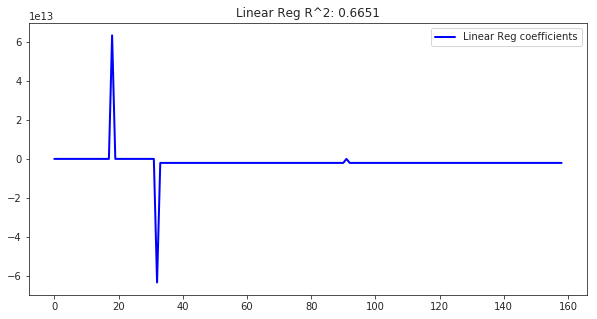

Alpha Ridge: 0.4387755102040817 

Score Train Ridge : 0.6651

Train RMSE Ridge    : 493.50 



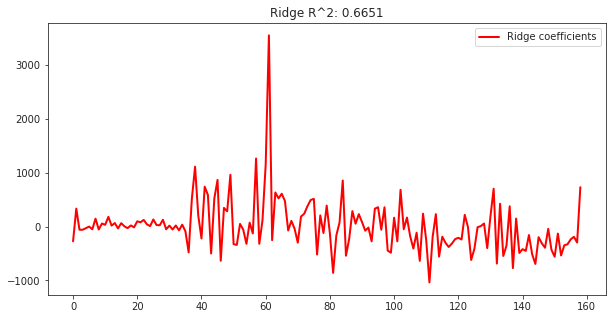

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Alpha LASSO: 0.007006012024048097 

Score Train Lasso : 0.6651

Train RMSE Lasso    : 493.49 



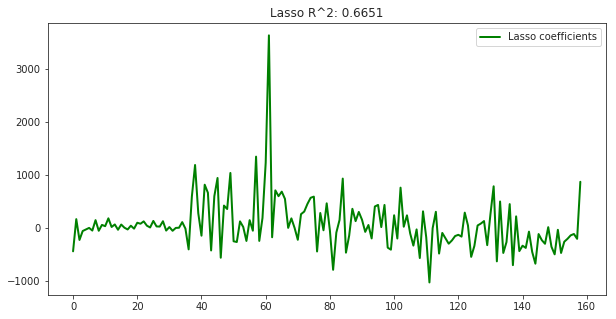

In [108]:
Linear_Regression(X_train,y_train)
Ridge_Regression(X_train,y_train)
Lasso_Regression(X_train,y_train)

In [82]:
al_net=0.01

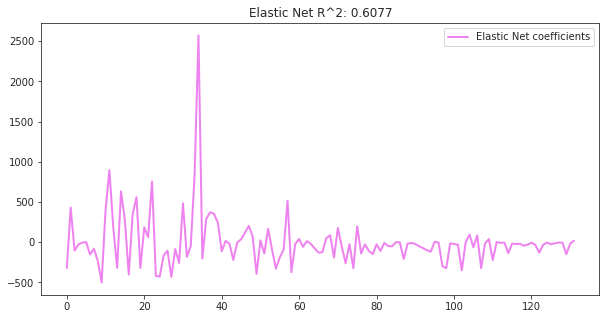

In [83]:
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt

enet = ElasticNet(alpha=al_net, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)

plot_coef('Elastic Net',enet.coef_,'violet', r2_score_enet)